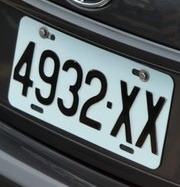

(180, 187)

45
135


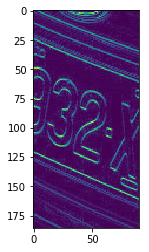

13.67447024492234
row=186, column=90
13.67447024492234


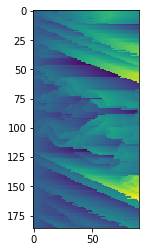

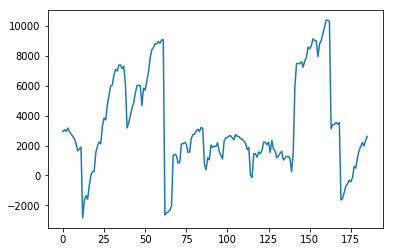

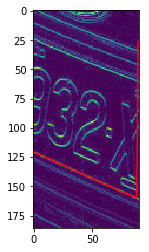

[120. 121. 122. 122. 122. 123. 123. 124. 124. 125. 125. 126. 126. 126.
 127. 127. 128. 128. 129. 129. 130. 130. 131. 131. 132. 132. 132. 133.
 133. 134. 134. 135. 135. 136. 136. 137. 137. 137. 138. 138. 139. 139.
 140. 140. 141. 141. 141. 142. 142. 143. 143. 144. 144. 145. 145. 146.
 146. 146. 147. 147. 148. 148. 149. 149. 150. 150. 150. 151. 151. 152.
 152. 153. 153. 154. 154. 155. 155. 155. 156. 156. 157. 157. 157. 158.
 158. 159. 159. 160. 160.  26.]


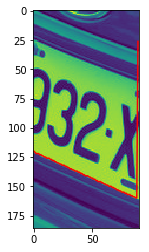

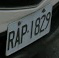

(59, 58)

14
44


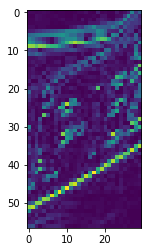

13.389801812865496
row=57, column=30
13.389801812865496


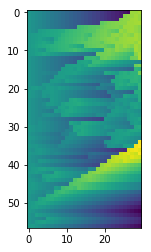

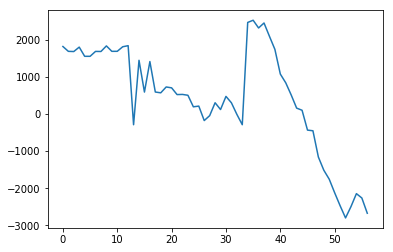

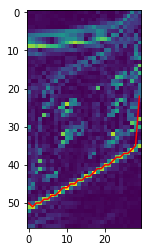

[50. 51. 50. 50. 49. 49. 48. 48. 47. 46. 46. 45. 45. 44. 44. 43. 43. 42.
 41. 41. 40. 40. 39. 38. 38. 37. 37. 36. 35. 22.]


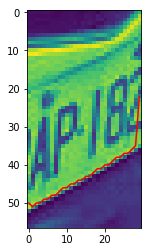

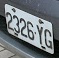

(59, 58)

14
44


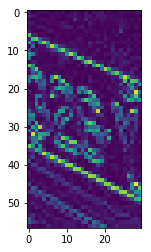

23.329039298245615
row=57, column=30
23.329039298245615


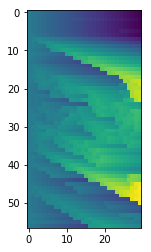

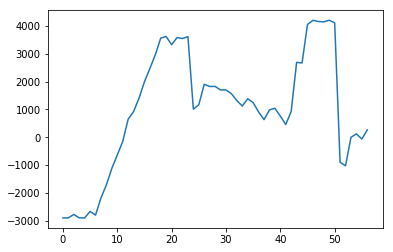

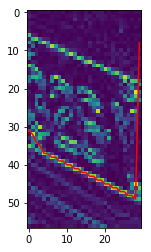

[31. 32. 34. 35. 37. 37. 38. 38. 39. 39. 40. 40. 41. 41. 42. 42. 43. 43.
 44. 44. 45. 45. 46. 46. 47. 47. 48. 48. 49.  8.]


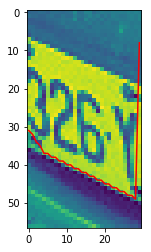

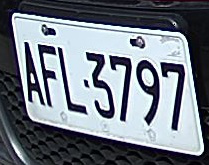

(209, 165)

52
156


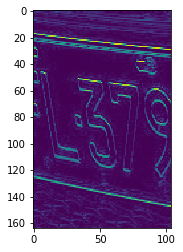

16.862901225375236
row=164, column=104
16.862901225375236


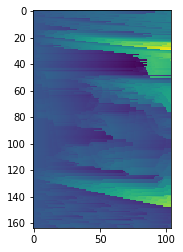

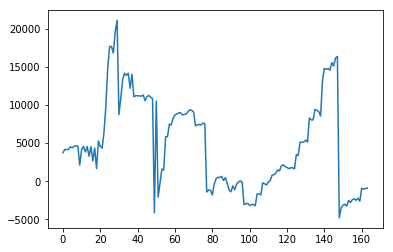

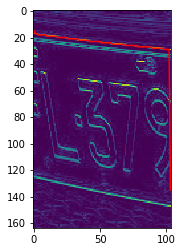

[ 15.  17.  17.  18.  18.  18.  18.  18.  18.  18.  19.  19.  19.  19.
  19.  19.  19.  19.  20.  20.  20.  20.  20.  20.  20.  20.  21.  21.
  21.  21.  21.  21.  21.  21.  22.  22.  22.  22.  22.  22.  22.  22.
  23.  23.  23.  23.  23.  23.  23.  23.  23.  24.  24.  24.  24.  24.
  24.  24.  24.  25.  25.  25.  25.  25.  25.  25.  25.  25.  25.  26.
  26.  26.  26.  26.  26.  26.  26.  26.  27.  27.  27.  27.  27.  27.
  27.  27.  27.  27.  27.  28.  28.  28.  28.  28.  28.  28.  28.  28.
  29.  29.  29.  29.  29. 135.]


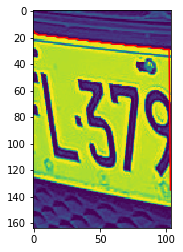

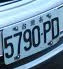

(63, 69)

15
47


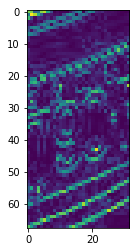

24.134093290441175
row=68, column=32
24.134093290441175


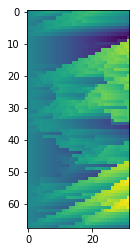

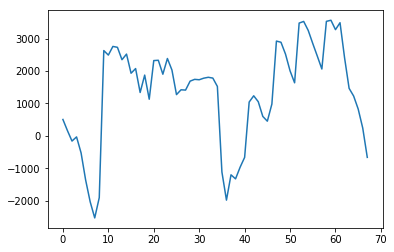

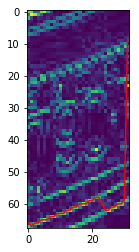

[66. 67. 66. 66. 65. 65. 65. 64. 64. 63. 63. 63. 62. 62. 61. 61. 60. 60.
 60. 59. 59. 58. 58. 60. 62. 62. 61. 61. 60. 60. 59.  9.]


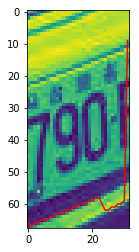

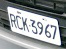

(66, 49)

16
49


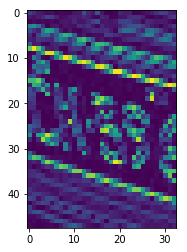

29.83191142676767
row=48, column=33
29.83191142676767


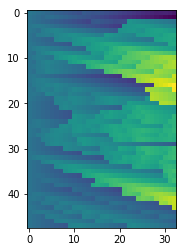

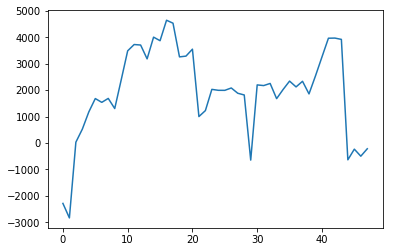

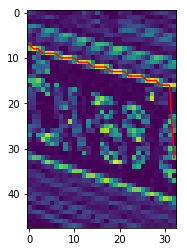

[ 7.  8.  8.  9.  9.  9.  9. 10. 10. 10. 10. 11. 11. 11. 12. 12. 12. 12.
 13. 13. 13. 13. 14. 14. 14. 14. 15. 15. 15. 16. 16. 16. 32.]


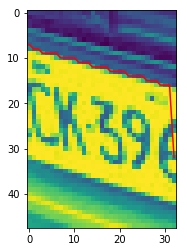

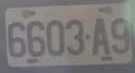

(135, 73)

33
101


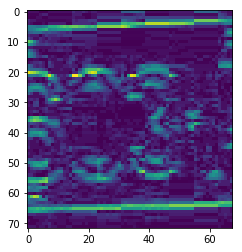

3.457424019607843
row=72, column=68
3.457424019607843


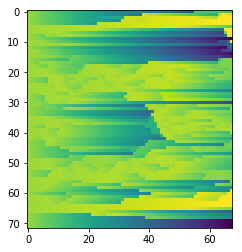

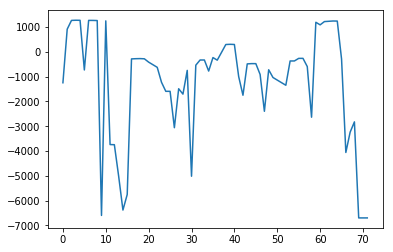

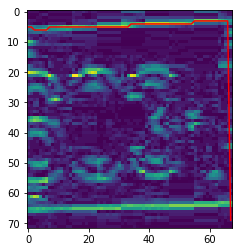

[ 5.  5.  6.  6.  6.  6.  6.  5.  5.  5.  5.  5.  5.  5.  5.  5.  5.  5.
  5.  5.  5.  5.  5.  5.  5.  5.  5.  5.  5.  5.  5.  5.  5.  5.  4.  4.
  4.  4.  4.  4.  4.  4.  4.  4.  4.  4.  4.  4.  4.  4.  4.  4.  4.  4.
  4.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3. 69.]


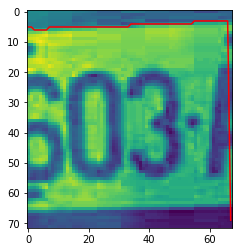

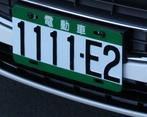

(147, 117)

36
110


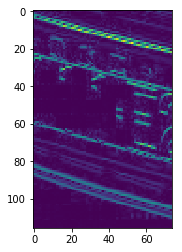

17.120522413793104
row=116, column=74
17.120522413793104


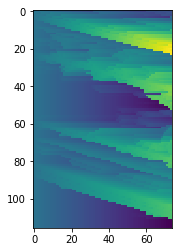

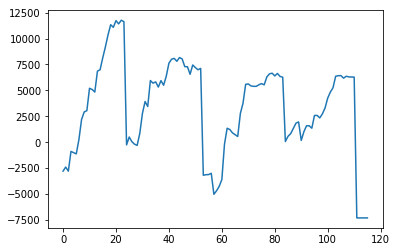

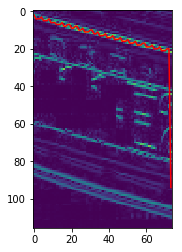

[ 2.  4.  4.  4.  3.  5.  5.  5.  4.  6.  6.  6.  7.  7.  7.  6.  8.  8.
  7.  7.  9.  9.  8.  8. 10. 10.  9. 11. 11. 11. 10. 10. 12. 12. 11. 13.
 13. 13. 12. 14. 14. 14. 13. 15. 15. 15. 14. 16. 16. 16. 15. 17. 17. 17.
 16. 18. 18. 18. 17. 17. 19. 19. 19. 18. 20. 20. 20. 19. 21. 21. 21. 20.
 20. 94.]


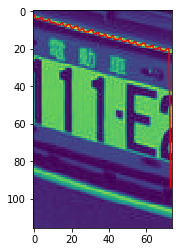

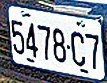

(107, 83)

26
80


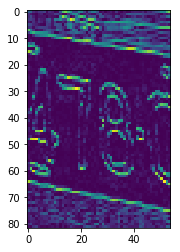

29.442222131887984
row=82, column=54
29.442222131887984


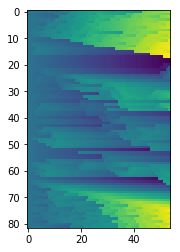

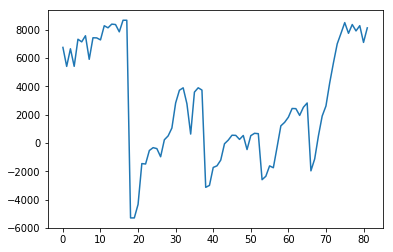

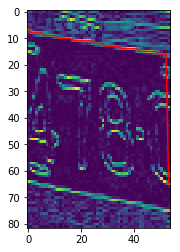

[ 6.  8.  8.  8.  8.  8.  9.  9.  9.  9.  9. 10. 10. 10. 10. 10. 10. 11.
 11. 11. 11. 11. 11. 11. 11. 12. 12. 12. 12. 13. 13. 13. 13. 13. 13. 14.
 14. 14. 14. 14. 14. 14. 15. 15. 15. 15. 15. 15. 15. 16. 16. 16. 16. 65.]


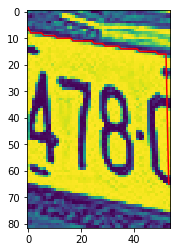

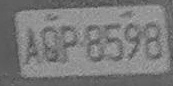

(173, 86)

43
129


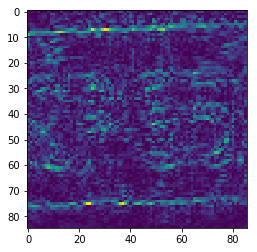

7.609362106703147
row=85, column=86
7.609362106703147


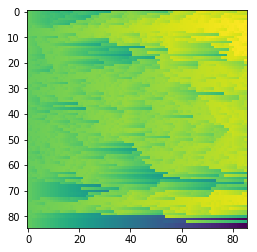

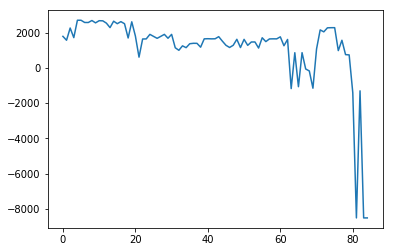

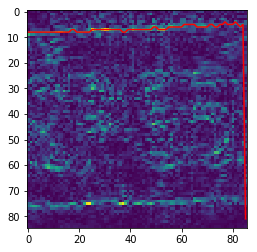

[ 8.  8.  8.  8.  8.  8.  8.  8.  8.  8.  8.  8.  8.  8.  8.  8.  8.  7.
  7.  8.  8.  8.  8.  8.  8.  7.  7.  7.  7.  7.  7.  7.  7.  7.  7.  7.
  7.  8.  8.  7.  7.  7.  7.  7.  7.  7.  7.  7.  7.  6.  6.  7.  7.  7.
  7.  6.  6.  6.  6.  6.  6.  5.  5.  5.  5.  5.  6.  6.  6.  6.  6.  5.
  5.  6.  6.  5.  5.  4.  5.  5.  5.  4.  5.  6.  5. 81.]


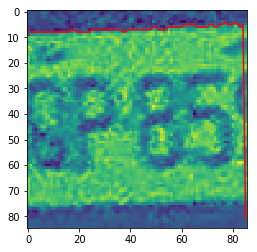

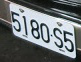

(81, 62)

20
60


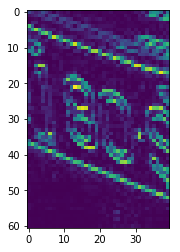

21.682661926229507
row=61, column=40
21.682661926229507


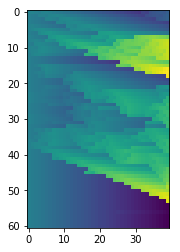

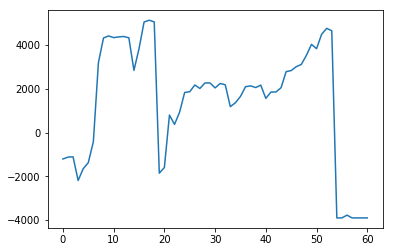

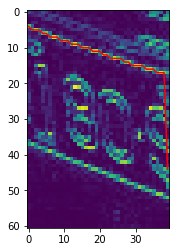

[ 4.  5.  5.  5.  6.  6.  7.  7.  7.  8.  8.  8.  9.  9.  9. 10. 10. 10.
 11. 11. 11. 12. 12. 13. 13. 13. 13. 14. 14. 15. 15. 15. 15. 16. 16. 16.
 17. 17. 17. 44.]


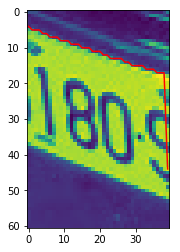

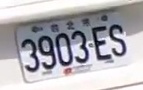

(143, 90)

35
107


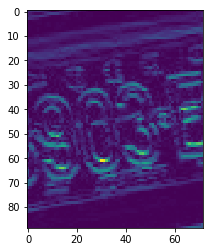

13.577632865168539
row=89, column=72
13.577632865168539


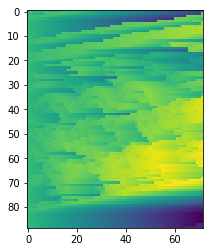

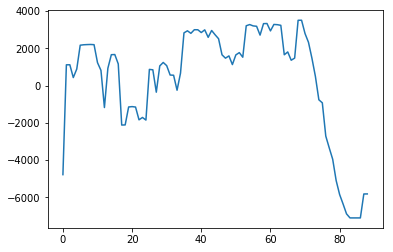

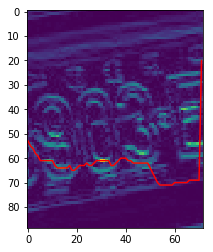

[53. 55. 56. 58. 59. 61. 61. 61. 61. 61. 61. 63. 64. 64. 64. 64. 64. 63.
 65. 65. 64. 63. 63. 63. 62. 63. 63. 62. 61. 61. 61. 61. 61. 61. 63. 63.
 62. 61. 60. 60. 60. 61. 61. 62. 62. 62. 62. 62. 62. 62. 64. 66. 68. 70.
 71. 71. 71. 71. 71. 71. 70. 70. 70. 70. 70. 70. 69. 69. 69. 69. 69. 20.]


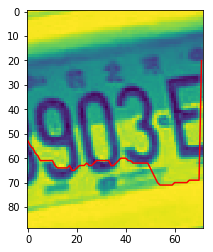

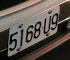

(70, 60)

17
52


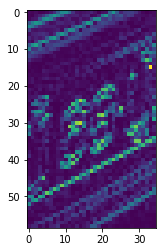

17.528866440677966
row=59, column=35
17.528866440677966


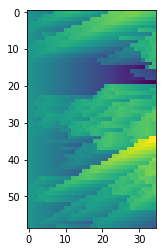

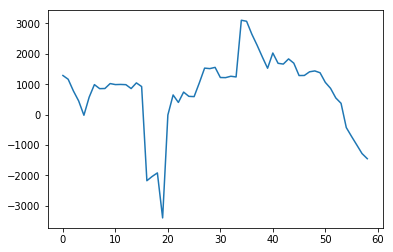

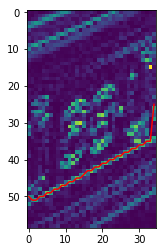

[50. 51. 51. 50. 50. 49. 49. 48. 48. 47. 47. 46. 46. 45. 45. 44. 43. 43.
 42. 42. 41. 41. 40. 40. 39. 39. 38. 38. 37. 37. 36. 36. 35. 35. 25.]


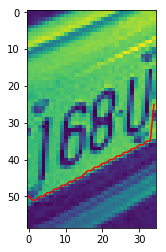

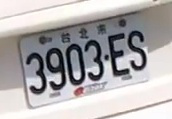

(172, 119)

43
129


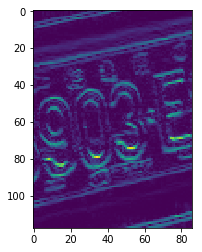

11.80213819471817
row=118, column=86
11.80213819471817


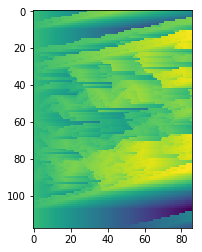

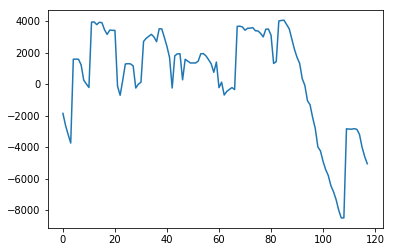

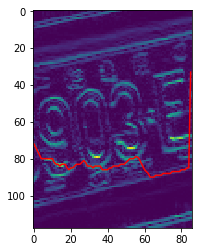

[72. 74. 76. 78. 80. 80. 80. 80. 80. 80. 80. 82. 83. 83. 84. 83. 83. 83.
 85. 86. 85. 85. 84. 83. 83. 83. 82. 81. 82. 84. 84. 84. 85. 84. 84. 84.
 84. 86. 86. 86. 86. 85. 85. 84. 84. 84. 84. 83. 83. 83. 82. 81. 80. 80.
 80. 79. 79. 80. 82. 84. 86. 87. 88. 90. 90. 90. 89. 89. 89. 89. 88. 88.
 88. 88. 88. 87. 87. 87. 87. 87. 86. 86. 86. 85. 85. 33.]


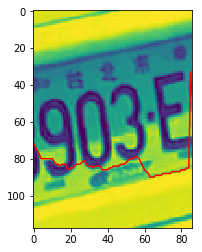

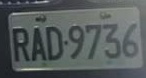

(146, 78)

36
109


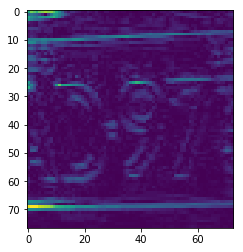

6.837505390499911
row=77, column=73
6.837505390499911


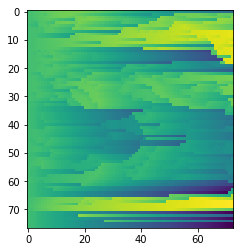

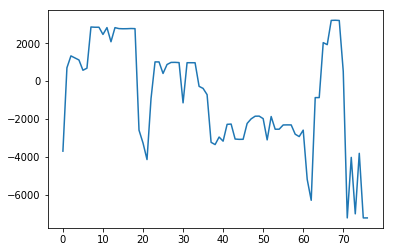

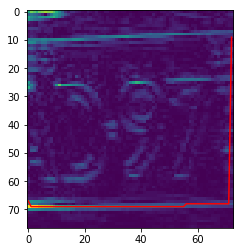

[67. 69. 69. 69. 69. 69. 69. 69. 69. 69. 69. 69. 69. 69. 69. 69. 69. 69.
 69. 69. 69. 69. 69. 69. 69. 69. 69. 69. 69. 69. 69. 69. 69. 69. 69. 69.
 69. 69. 69. 69. 69. 69. 69. 69. 69. 69. 69. 69. 69. 69. 69. 69. 69. 69.
 69. 69. 68. 68. 68. 68. 68. 68. 68. 68. 68. 68. 68. 68. 68. 68. 68. 68.
  9.]


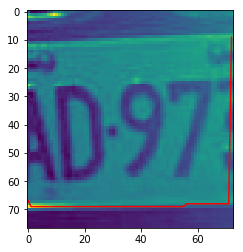

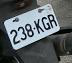

(72, 63)

18
54


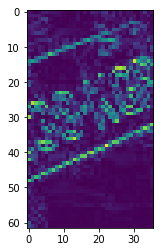

24.689397670250894
row=62, column=36
24.689397670250894


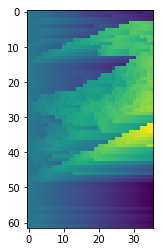

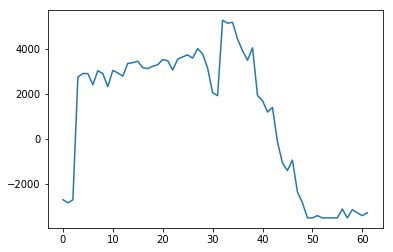

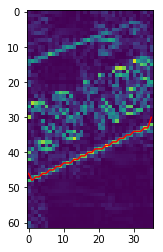

[46. 48. 47. 47. 46. 46. 45. 45. 44. 44. 43. 43. 43. 42. 42. 41. 41. 40.
 40. 39. 39. 39. 38. 38. 37. 37. 36. 36. 35. 35. 34. 34. 34. 33. 33. 30.]


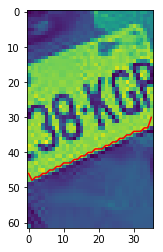

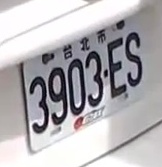

(162, 167)

40
121


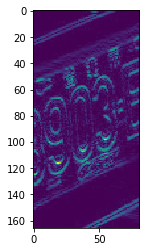

8.894820667856612
row=166, column=81
8.894820667856612


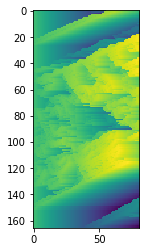

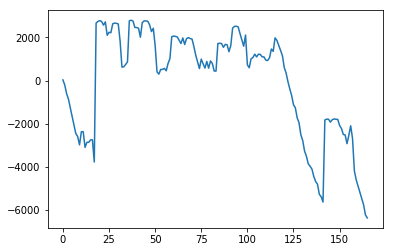

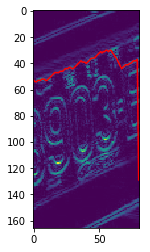

[ 53.  54.  54.  53.  53.  53.  52.  52.  52.  53.  53.  52.  51.  50.
  49.  48.  47.  47.  47.  47.  46.  46.  46.  45.  44.  44.  44.  43.
  43.  44.  44.  43.  42.  41.  40.  39.  38.  39.  39.  39.  40.  39.
  38.  37.  36.  36.  36.  35.  34.  33.  32.  31.  32.  31.  31.  30.
  30.  31.  30.  30.  32.  33.  35.  36.  38.  40.  42.  44.  43.  42.
  41.  41.  41.  40.  40.  39.  38.  38.  38.  37. 129.]


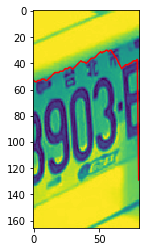

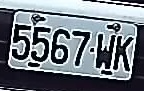

(144, 91)

36
108


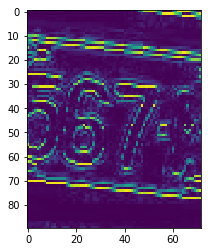

30.04665438271605
row=90, column=72
30.04665438271605


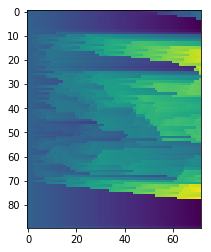

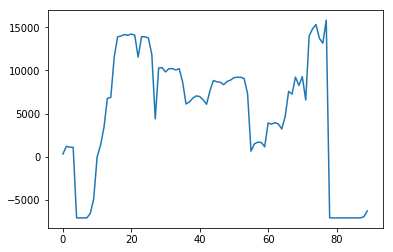

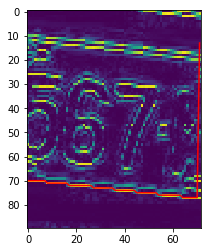

[70. 70. 70. 70. 70. 70. 70. 70. 71. 71. 71. 71. 71. 71. 71. 71. 71. 72.
 72. 72. 72. 72. 72. 72. 72. 72. 72. 73. 73. 73. 73. 73. 73. 73. 73. 73.
 74. 74. 74. 74. 74. 74. 74. 74. 74. 75. 75. 75. 75. 75. 75. 75. 75. 75.
 76. 76. 76. 76. 76. 76. 76. 76. 76. 76. 77. 77. 77. 77. 77. 77. 77. 13.]


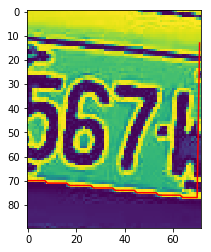

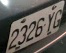

(66, 53)

16
49


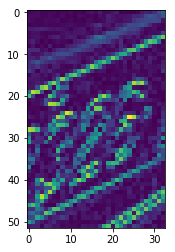

18.787364627039626
row=52, column=33
18.787364627039626


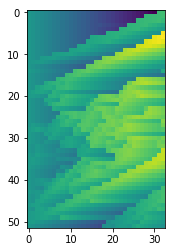

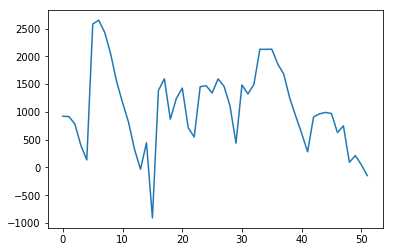

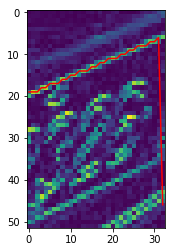

[19. 19. 19. 18. 18. 17. 17. 17. 16. 16. 15. 15. 14. 14. 14. 13. 13. 12.
 12. 11. 11. 11. 10. 10.  9.  9.  8.  8.  8.  7.  7.  6. 46.]


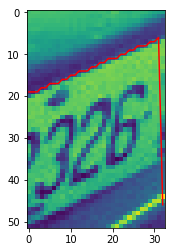

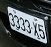

(51, 47)

12
38


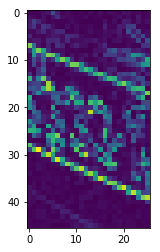

28.832373327759196
row=46, column=26
28.832373327759196


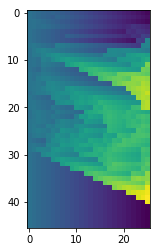

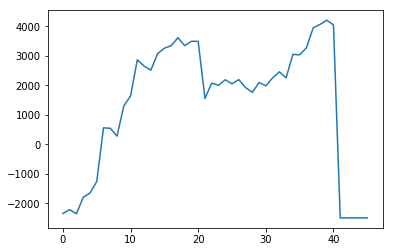

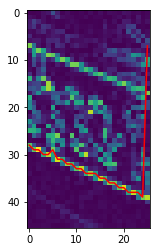

[28. 29. 29. 30. 30. 29. 31. 31. 32. 32. 33. 33. 34. 34. 34. 35. 35. 36.
 36. 37. 37. 38. 38. 38. 39.  7.]


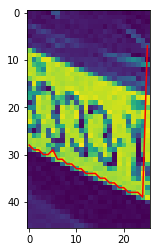

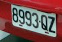

(62, 42)

15
46


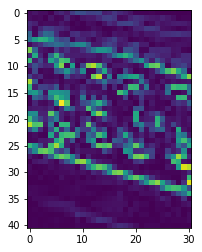

24.54309449252557
row=41, column=31
24.54309449252557


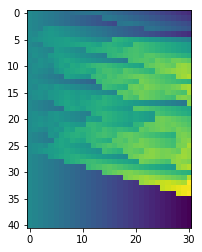

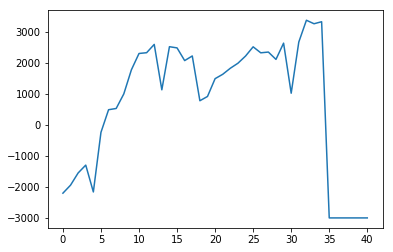

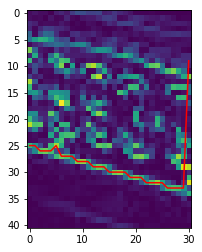

[25. 25. 26. 26. 26. 25. 27. 27. 27. 28. 28. 28. 29. 29. 29. 30. 30. 30.
 30. 31. 31. 31. 32. 32. 32. 32. 33. 33. 33. 33.  9.]


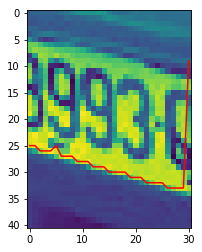

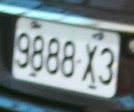

(134, 112)

33
100


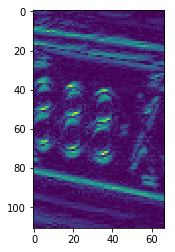

10.5119592039801
row=111, column=67
10.5119592039801


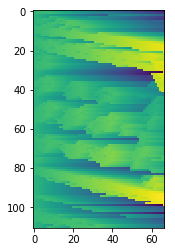

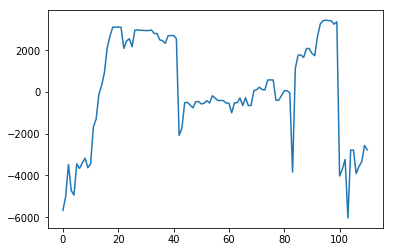

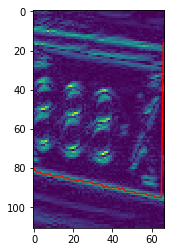

[80. 82. 82. 82. 83. 83. 83. 83. 83. 84. 84. 84. 84. 84. 84. 85. 85. 85.
 86. 86. 86. 86. 87. 86. 86. 87. 87. 87. 87. 87. 88. 88. 88. 88. 88. 89.
 90. 89. 90. 90. 90. 90. 90. 90. 91. 90. 91. 92. 92. 92. 92. 92. 93. 93.
 93. 93. 93. 93. 94. 94. 94. 94. 95. 95. 95. 95. 16.]


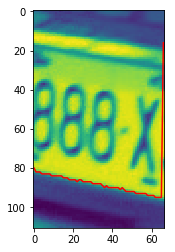

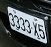

(51, 47)

12
38


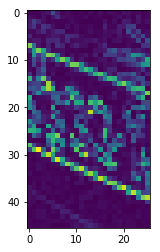

28.832373327759196
row=46, column=26
28.832373327759196


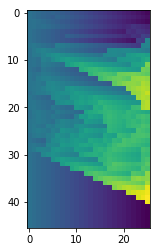

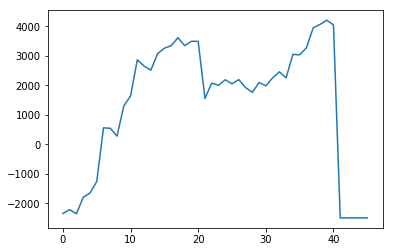

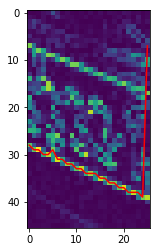

[28. 29. 29. 30. 30. 29. 31. 31. 32. 32. 33. 33. 34. 34. 34. 35. 35. 36.
 36. 37. 37. 38. 38. 38. 39.  7.]


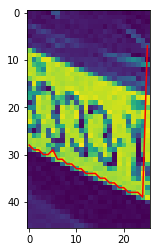

In [65]:
import pandas as pd
import os, sys
import numpy as np
import math
from matplotlib import pyplot as plt
from IPython.display import display
from PIL import Image
import PIL
import s3fs 

def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])

def dpDdecode(img, row, column, side):
    
    print("row={}, column={}".format(row, column))
    thread=np.mean(img)
    print(thread)
    reward= np.zeros((row,column),dtype=float)
    prev= np.zeros((row,column),dtype=float)
    #print(prev.shape)
    for j in range(0,row):  # for each reward
        prev[j,0]=0;
        if img[j,0] < thread :
            reward[j,0]=0
        else:
            reward[j,0]=100
        #display(reward[:,0])        

    columnTrace=column
    #columnTrace=4
    for i in range(1, columnTrace):  # for each stage
        for j in range(0,row):  # for each reward
        #for j in range(1,row-1):  # for each reward
            if img[j,i] < thread : # white
                reward[j,i] = reward[j,i-1]-100 
                prev[j,i] =j #debug of edge :0
            else: #black
                #newReward=np.zeros([row],dtype=float)
                
                #newReward=reward[:,i-1]
                newReward=np.array(reward[:,i-1], copy=True)
                #imgstrip=img[:,i]*img[:,i-1]
                #print(imgstrip.size)
                #print('pixel at img[{},{}]'.format)
                #print(newReward)
                down=max(j-side,0)
                up=min(j+side,row)
                for k in range(down,up):
                    #print(abs(img[j,i]-img[k,i-1]))
                    ###########newReward[k]=newReward[k]-abs(img[j,i]-img[k,i-1])#*(abs(k-j)+1)#+abs(j/row-0.5)#-np.count_nonzero(imgstrip[k:j]!=0)/row*1000+ abs(j/row-0.5)
                    #print(newReward[k])
                    newReward[k]=newReward[k]+img[j,i]
                #print(newReward[down:up])
                relativeMaxIndex=np.argmax(newReward[down:up])
                maxreward=newReward[relativeMaxIndex+down]
                #print('{},{} : maxreward={}'.format(i,j,maxreward))
                reward[j,i] = maxreward
                prev[j,i] = relativeMaxIndex+down
    plt.imshow(reward)
    plt.show()


                
    # traceback
    #display(reward[:,columnTrace-1])        
    finalMaxIndex=np.argmax(reward[:,columnTrace-1])
    plt.plot(reward[:,columnTrace-1])
    plt.show()
    #display(reward[finalMaxIndex,columnTrace-1])
    tmpIndex=finalMaxIndex
    #print(finalMaxIndex)
    data_r=np.zeros(columnTrace)
    data_r[columnTrace-1]=row-tmpIndex

        
    for i in range(columnTrace-1, 0, -1):  # for each stage
        #print(tmpIndex)
        #print(reward[tmpIndex,i])
        tmpIndex=int(prev[tmpIndex,i])
        #data_r[i-1]=row-tmpIndex
        data_r[i-1]=tmpIndex
    plt.imshow(img)
    plt.plot(data_r,'r')
    plt.show()
    return data_r


def lp_parser(path,rowOffset, columnOffset, h, w):
    im = Image.open(path)
    display(im)
    display(im.size)
    pix_color = np.array(im)
    pix_gray = rgb2gray(pix_color)
    left=int(im.size[0]/4)
    print(left)
    
    right=int(3*im.size[0]/4)
    print(right)
    cropGray=np.abs(pix_gray[0:-1,left:right]-pix_gray[1:,left:right])
    plt.imshow(cropGray)
    plt.show()
    #display(pix_gray)
    thread=np.mean(cropGray)
    print(thread)
    

    wave=dpDdecode(cropGray,cropGray.shape[0],cropGray.shape[1],2)
    print(wave)

    plt.imshow(pix_gray[0:-1,left:right])
    plt.plot(wave,'r')
    plt.show()
    return wave
testPath='img/0_1111E2_1.jpg'
testPath='img/0_3333X5_1.jpg'
for root,unkown,fNames in os.walk('img'):
    for f in fNames:
        strFpath="img/{}".format(f)
        lpRect=lp_parser(strFpath, 413, 178, 472, 737)
        
lpRect=lp_parser(testPath, 413, 178, 472, 737)

